In [1]:
pip install tensorflow==2.12.0

  Obtaining dependency information for tensorflow==2.12.0 from https://files.pythonhosted.org/packages/3f/b2/33372601ed71fb41049642f8f6e1e142215e8b5c3463df434fc8885db278/tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
# to share the GPU resources for multiple sessions
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

%matplotlib inline

Device mapping: no known devices.


2024-11-11 08:24:48.702276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-11 08:24:48.702434: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
my_data_dir = 'dataset/cell_images'

In [11]:
os.listdir(my_data_dir)

['test', 'train']

In [12]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [13]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [14]:
len(os.listdir(train_path+'/uninfected/'))

12479

In [15]:
len(os.listdir(train_path+'/parasitized/'))

12479

In [16]:
os.listdir(train_path+'/parasitized')[0]

'C182P143NThinF_IMG_20151201_172257_cell_157.png'

In [17]:
para_img= imread(train_path+
                 '/parasitized/'+
                 os.listdir(train_path+'/parasitized')[0])

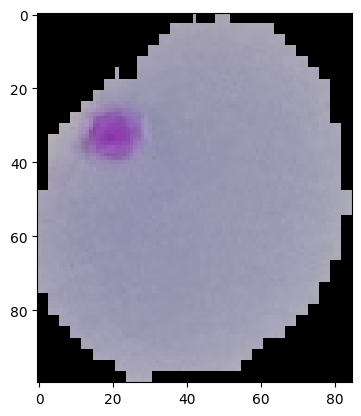

In [18]:
plt.imshow(para_img)

In [20]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

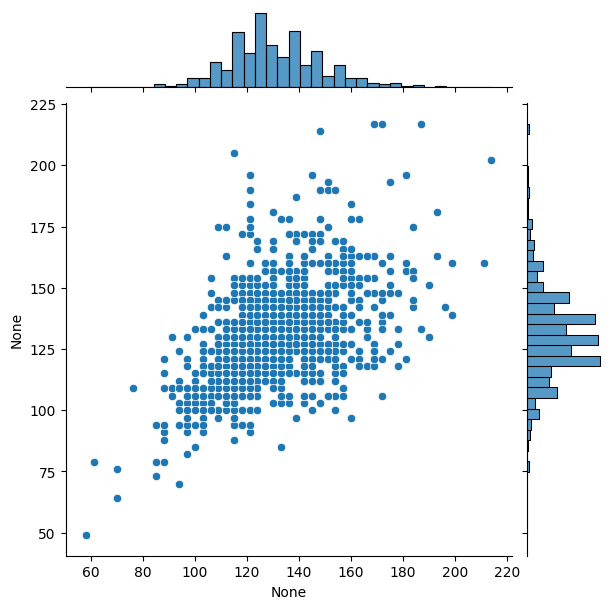

In [21]:
sns.jointplot(x=dim1,y=dim2)

In [22]:
image_shape = (130,130,3)

In [23]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more informati

In [24]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [25]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [26]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [27]:
model = models.Sequential()

# Add convolutional layers
model.add(layers.Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the layer
model.add(layers.Flatten())

# Add a dense layer
model.add(layers.Dense(128, activation='relu'))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2024-11-11 08:39:29.442194: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-11 08:39:29.442410: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [29]:
batch_size = 16

In [30]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Args:
        directory: string, path to the target directory. It should contain
          one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
          inside each of the subdirectories directory tree will be included
          in the generator. See [this script](
          https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
          for more details.
        target_size: Tuple of integers `(height, width)`, defaults to `(256,
          256)`. The dimensions

In [31]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [32]:
train_image_gen.batch_size

16

In [33]:
len(train_image_gen.classes)

24958

In [34]:
train_image_gen.total_batches_seen

0

In [35]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [36]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [38]:
results = model.fit(train_image_gen,epochs=3,
                              validation_data=test_image_gen
                             )

Epoch 1/3
   1/1560 [..............................] - ETA: 4:25 - loss: 0.3287 - accuracy: 0.9375

2024-11-11 08:42:01.011084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1560/1560 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9238

2024-11-11 08:45:37.498858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1560/1560 [==============================] - 234s 150ms/step - loss: 0.2330 - accuracy: 0.9238 - val_loss: 0.1904 - val_accuracy: 0.9385
Epoch 2/3
1560/1560 [==============================] - 314s 201ms/step - loss: 0.1746 - accuracy: 0.9448 - val_loss: 0.1651 - val_accuracy: 0.9519
Epoch 3/3
1560/1560 [==============================] - 472s 302ms/step - loss: 0.1621 - accuracy: 0.9492 - val_loss: 0.1510 - val_accuracy: 0.9512


In [39]:
model.save('cell_model.h5')

In [40]:
losses = pd.DataFrame(model.history.history)


<Axes: >

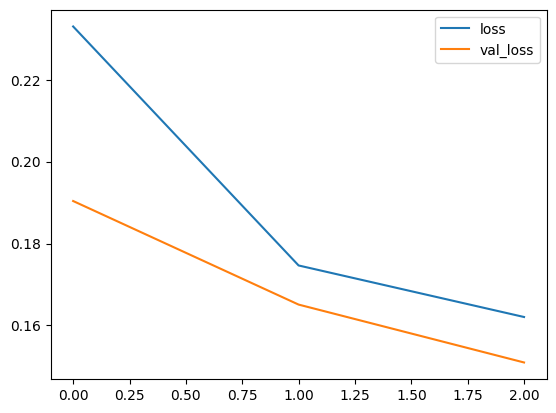

In [41]:
losses[['loss','val_loss']].plot()


In [42]:
model.metrics_names


['loss', 'accuracy']

In [43]:
model.evaluate(test_image_gen)


2024-11-11 08:59:59.270278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


163/163 [==============================] - 31s 190ms/step - loss: 0.1573 - accuracy: 0.9454


[0.15732260048389435, 0.9453846216201782]

In [44]:
pred_probabilities = model.predict(test_image_gen)


2024-11-11 09:00:40.447331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


163/163 [==============================] - 31s 189ms/step


In [45]:
test_image_gen.classes


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [46]:
predictions = pred_probabilities > 0.5


In [50]:
print ("Name : Pavithran MJ ")
print ("Reg no: 212223240112")
print(classification_report(test_image_gen.classes,predictions))


Name : Pavithran MJ 
Reg no: 212223240112
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1300
           1       0.93      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [51]:
print ("Name : Pavithran MJ ")
print ("Reg no: 212223240112")
confusion_matrix(test_image_gen.classes,predictions)


Name : Pavithran MJ 
Reg no: 212223240112


array([[1208,   92],
       [  48, 1252]])

In [52]:
import random
import tensorflow as tf
list_dir=["uninfected"]
dir_=(random.choice(list_dir))
para_img= imread(train_path+
                 '/'+dir_+'/'+
                 os.listdir(train_path+'/'+dir_)[random.randint(0,100)])
img  = tf.convert_to_tensor(np.asarray(para_img))
img = tf.image.resize(img,(130,130))

In [53]:
img=img.numpy()
pred=bool(model.predict(img.reshape(1,130,130,3))<0.5)

1/1 [==============================] - 0s 264ms/step


Name : Pavithran MJ 
Reg no: 212223240112


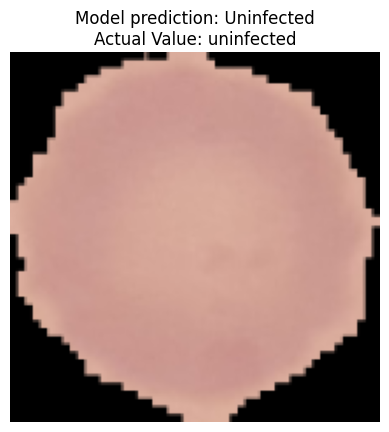

In [54]:
print ("Name : Pavithran MJ ")
print ("Reg no: 212223240112")
plt.title("Model prediction: "+("Parasitized" if pred  else "Uninfected")+"\nActual Value: "+str(dir_))
plt.axis("off")
plt.imshow(img)
plt.show()